In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [2]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

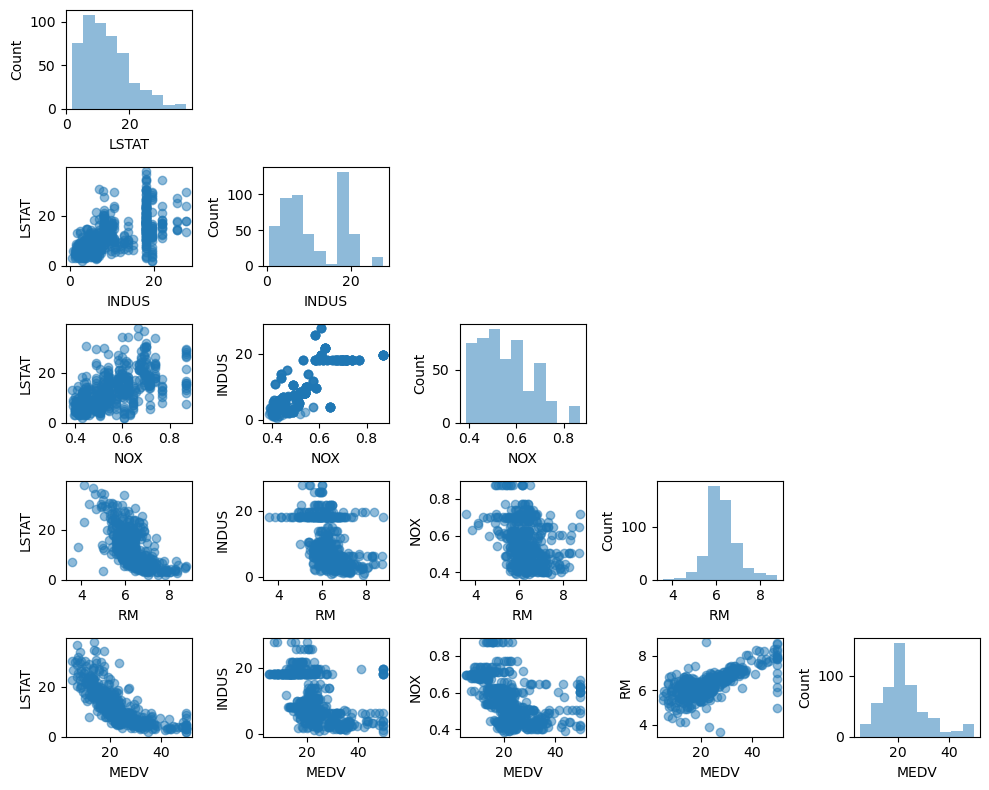

In [3]:
# 삼점도 행렬
cols = ['LSTAT','INDUS','NOX','RM','MEDV']

scatterplotmatrix(df[cols].values, figsize = (10,8),
                 names = cols, alpha = 0.5)
plt.tight_layout()
plt.show()

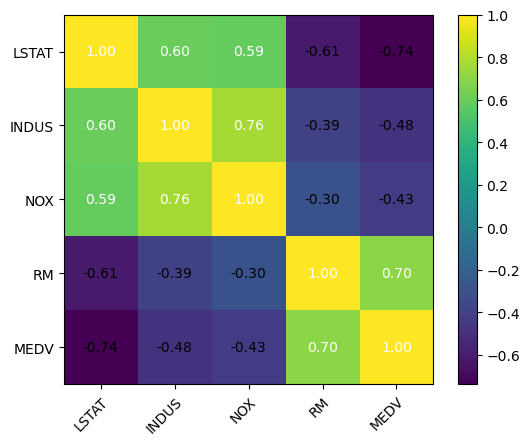

In [4]:
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm,
            row_names = cols,
            column_names = cols)
plt.show()

# 최소 제곱 선형회귀 모델 구현

In [11]:
class LinearRegressionGD(object):
    
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1+ X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_[1:]+self.w_[0])
    def predict(self, X):
        return self.net_input(X)

In [12]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

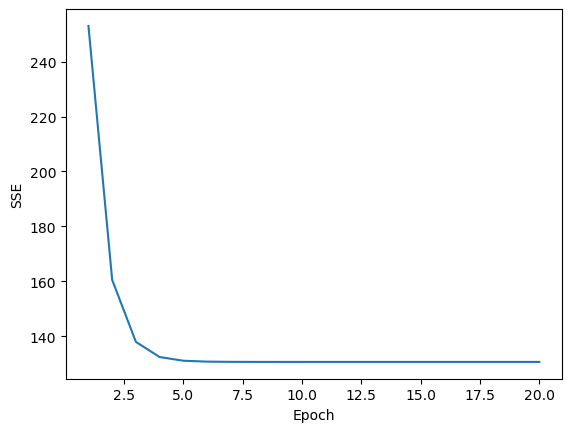

In [13]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [14]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c = 'steelblue', edgecolor = 'white', s = 70)
    plt.plot(X, model.predict(X), color = 'black',lw =2)
    return None

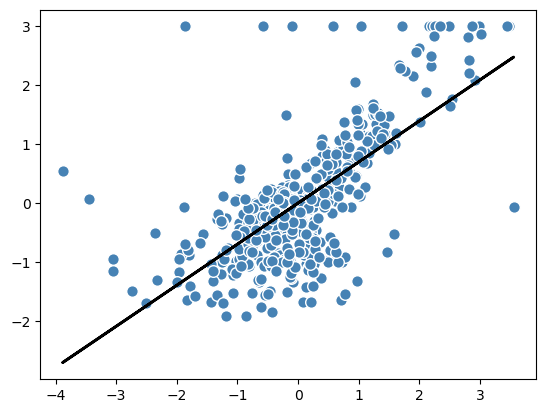

In [15]:
lin_regplot(X_std, y_std, lr)

In [18]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("$1,000 단위 가격: %.3f" % sc_y.inverse_transform(price_std.reshape(-1,1)))

$1,000 단위 가격: 10.840


In [19]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print(slr.coef_[0])
print(slr.intercept_)

9.10210898118031
-34.67062077643857


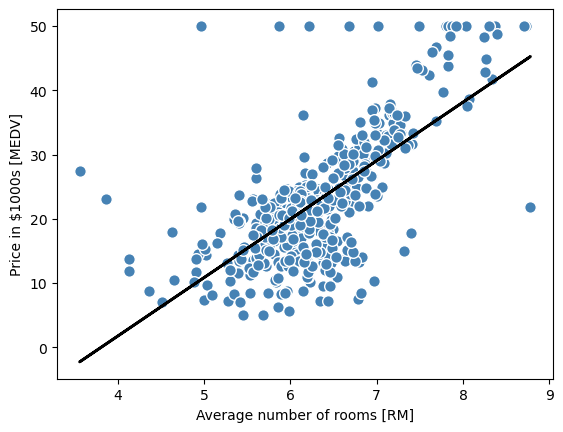

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

# plt.savefig('images/10_07.png', dpi=300)
plt.show()

In [21]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples = 50,
                        loss = 'absolute_error',
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(X,y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=0,
                residual_threshold=5.0)

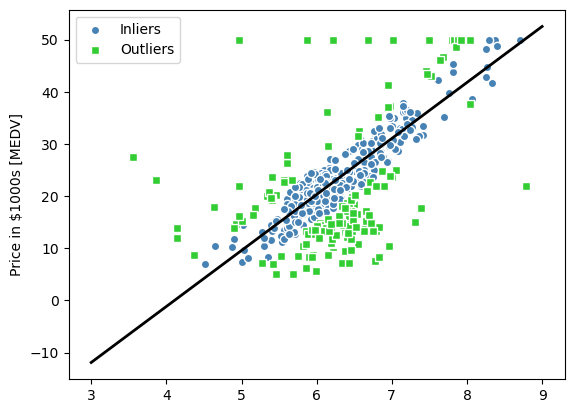

In [26]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
           c = 'steelblue', edgecolor = 'white',
           marker = 'o',label = 'Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c = 'limegreen', edgecolor = 'white',
           marker = 's',label = 'Outliers')

plt.plot(line_X, line_y_ransac, color ='black', lw =2)
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

# plt.savefig('images/10_08.png', dpi=300)
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

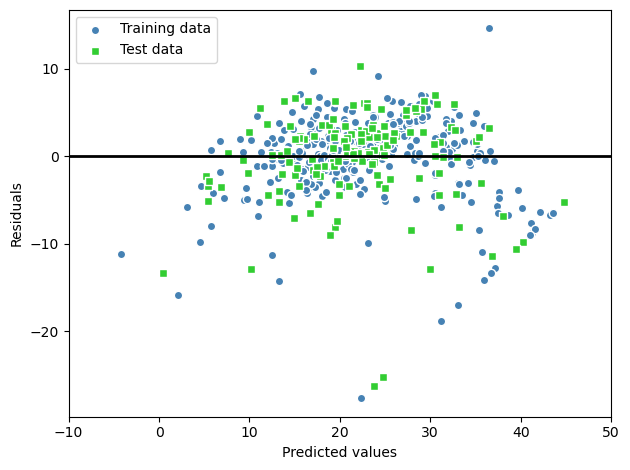

In [30]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 19.958, 테스트 MSE: 27.196
훈련 R^2: 0.765, 테스트 R^2: 0.673


# 선형 회귀 모델을 다항회귀로 변환

In [31]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [32]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

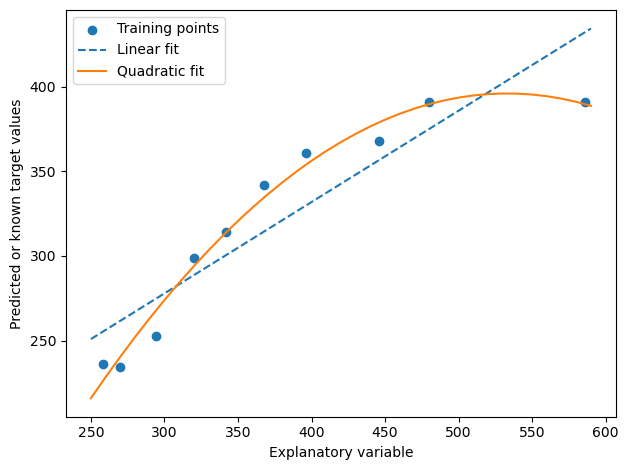

In [33]:
# 선형 특성 학습
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 이차항 특성 학습
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# 결과 그래프
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/10_11.png', dpi=300)
plt.show()

In [34]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [35]:
print('훈련 MSE 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('훈련 R^2 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

훈련 MSE 비교 - 선형 모델: 569.780, 다항 모델: 61.330
훈련 R^2 비교 - 선형 모델: 0.832, 다항 모델: 0.982
